In [316]:
import tensorflow as tf
import numpy as np#
from scipy.spatial import distance
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, regularizers, optimizers



In [317]:
vocabulary_size = 10_000
sequence_length = 135

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocabulary_size)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=sequence_length)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=sequence_length)

In [274]:
print(x_train.shape)
print(x_test.shape)

(25000, 135)
(25000, 135)


In [275]:
# split (here we didn't shuffle as the the data is already shuffle)
split_index = int(0.8 * len(x_train))

imdb_train = tf.data.Dataset.from_tensor_slices((x_train[:split_index], y_train[:split_index])).cache()

imdb_validate = tf.data.Dataset.from_tensor_slices((x_train[split_index:], y_train[split_index:])).cache()

imdb_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).cache()


In [276]:
random_review, random_label = list(imdb_train.shuffle(10000).take(1))[0]
print(random_review)
print(random_review.shape)
print(random_label)


tf.Tensor(
[ 730  930 4524  131 2884   11    6  176    7 2427    5    2 6530  388
    4  226   86  511 8850    2   39  136    8  136    4 1280  223  113
    7    4  293  554  632   19    4 1103  182    5    4  445   74    9
 9885    2    5  137    4  277  127   28    6  227    7   35 5163 1251
   15   26 1141    7 8518  157    4 5888    7 1217    5 5074  572    4
 1210  325 1210 1060  749    7  406    2    9  184 1543 3049   17 8381
    5    2  253   17   85   87 4524  108   64  305    7  120    4  350
 1789    5  599   29  408  178   35 2203 1166    7 1939    5 6385   39
  860 3834    2    2 3708 2864 4425    5    2 4561   83   35 3268 3285
    2 1154    2    2    5   31    7 8518  118], shape=(135,), dtype=int32)
(135,)
tf.Tensor(1, shape=(), dtype=int64)


In [277]:
embedding_size = 155

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.011)))
model.summary()

model.compile(optimizer=optimizers.Nadam(),
              loss='binary_crossentropy',
              metrics=['accuracy']  )

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 135, 155)          1550000   
_________________________________________________________________
flatten_38 (Flatten)         (None, 20925)             0         
_________________________________________________________________
dense_49 (Dense)             (None, 10)                209260    
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 11        
Total params: 1,759,271
Trainable params: 1,759,271
Non-trainable params: 0
_________________________________________________________________


In [278]:
loss, accuracy = model.evaluate(imdb_test.batch(32))
loss, accuracy

782/782 [==============================] - 1s 2ms/step - loss: 0.9047 - accuracy: 0.5048


(0.9047200679779053, 0.504800021648407)

In [279]:
history = model.fit(imdb_train.shuffle(10000).batch(32), epochs=5, validation_data=imdb_validate.batch(32))

Epoch 1/5
625/625 [==============================] - 7s 11ms/step - loss: 0.5601 - accuracy: 0.7849 - val_loss: 0.4765 - val_accuracy: 0.8544
Epoch 2/5
625/625 [==============================] - 7s 11ms/step - loss: 0.4105 - accuracy: 0.8933 - val_loss: 0.4788 - val_accuracy: 0.8474
Epoch 3/5
625/625 [==============================] - 7s 11ms/step - loss: 0.3552 - accuracy: 0.9323 - val_loss: 0.4857 - val_accuracy: 0.8568
Epoch 4/5
625/625 [==============================] - 7s 12ms/step - loss: 0.3063 - accuracy: 0.9625 - val_loss: 0.5013 - val_accuracy: 0.8548
Epoch 5/5
625/625 [==============================] - 8s 12ms/step - loss: 0.2691 - accuracy: 0.9798 - val_loss: 0.5044 - val_accuracy: 0.8512


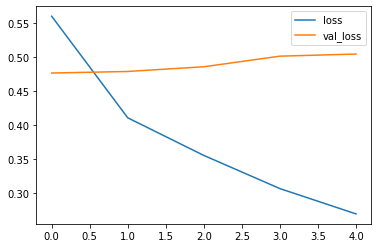

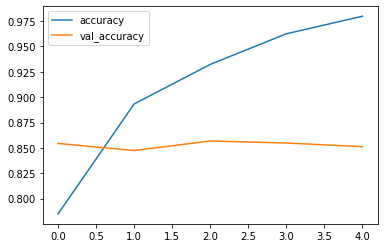

In [280]:
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.close()

plt.plot(model.history.history['accuracy'], label='accuracy')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.close()

In [283]:
# 625/625 [==============================] - 1s 2ms/step - loss: 0.3422 - accuracy: 0.9016 - val_loss: 0.4603 - val_accuracy: 0.8108
#625/625 [==============================] - 2s 3ms/step - loss: 0.1859 - accuracy: 0.9851 - val_loss: 0.4438 - val_accuracy: 0.8346
#625/625 [==============================] - 5s 8ms/step - loss: 0.3744 - accuracy: 0.9237 - val_loss: 0.4769 - val_accuracy: 0.8600

In [284]:
loss, accuracy  = model.evaluate(imdb_test.batch(512))
loss, accuracy

49/49 [==============================] - 1s 11ms/step - loss: 0.5052 - accuracy: 0.8530


(0.5051987171173096, 0.8529999852180481)

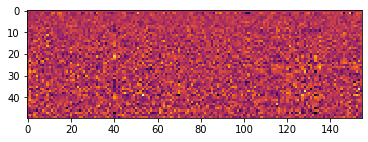

In [285]:
plt.imshow(model.layers[0].get_weights()[0][:50,:], cmap='inferno')

In [286]:
# specific for the imndb dataset
word_index = imdb.get_word_index()
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<UNUSED>'] = 3

In [287]:
def get_embedding_of_word(word):
    
    assert word in word_index
    index = word_index[word]
    embedding = model.layers[0].get_weights()[0][index]
    return embedding


In [288]:
get_embedding_of_word('king')

array([ 0.03119032,  0.02512479, -0.024209  , -0.00823046, -0.0410824 ,
       -0.02588836, -0.00047093, -0.0394575 , -0.03298425,  0.01069069,
        0.0109676 , -0.05245185, -0.00506377, -0.05133441,  0.04538849,
       -0.01666553, -0.02245323,  0.04692054,  0.03797558, -0.04766341,
        0.06122426, -0.04737053, -0.06679348, -0.03906728,  0.02579962,
        0.04712842,  0.07205603, -0.04773847,  0.08567491, -0.01421202,
        0.00331013, -0.05006907, -0.03363525, -0.04318298, -0.11350923,
       -0.09509663, -0.01488608, -0.05516377,  0.04509208, -0.01927194,
        0.1318201 ,  0.00927963, -0.00461384,  0.02658102, -0.05440787,
        0.01874255, -0.02231516,  0.01949824,  0.07538221,  0.03931703,
       -0.00667408,  0.02718044, -0.04804491,  0.03650832, -0.03201131,
        0.05515321,  0.02138654, -0.11029867,  0.04188513, -0.0088248 ,
        0.04441949, -0.03312579,  0.01470127,  0.01375614, -0.0125558 ,
        0.00856685,  0.08821899,  0.04854232, -0.06345931, -0.03

In [289]:
from scipy.spatial import distance
# find the distance between 
distance.cosine(get_embedding_of_word('king'), get_embedding_of_word('bitch'))

0.8107765763998032

In [290]:
distance.cosine(get_embedding_of_word('i'), get_embedding_of_word('me'))


1.0595577023923397

In [311]:
# use the glove emmbedings asstarting ebbemdings 
embedding_size = 100
embedding_index = {}
with open( "glove.6B.100d.txt") as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs
    word_index = imdb.get_word_index()
    max_words = 10000
    embedding_matrix = np.zeros((vocabulary_size, embedding_size))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if i < vocabulary_size - 3 and embedding_vector is not None:
            embedding_matrix[i + 3] = embedding_vector
    print(embedding_matrix.shape)

(10000, 100)


In [314]:
model = models.Sequential()
model.add(layers.Embedding(
    vocabulary_size, 
    embedding_size, 
    input_length=sequence_length
))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.011)))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

model.summary()
model.compile(
    optimizer="adam", 
    loss="binary_crossentropy",
    metrics=["accuracy"])
history = model.fit(
    imdb_train.shuffle(10000).batch(32),
    epochs=10,
    validation_data=imdb_validate.batch(32)
)

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_63 (Embedding)     (None, 135, 100)          1000000   
_________________________________________________________________
flatten_54 (Flatten)         (None, 13500)             0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 13501     
Total params: 1,013,501
Trainable params: 1,013,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5862 - accuracy: 0.7164 - val_loss: 0.4800 - val_accuracy: 0.8060
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3647 - accuracy: 0.8777 - val_loss: 0.4470 - val_accuracy: 0.8320
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2818 - accura

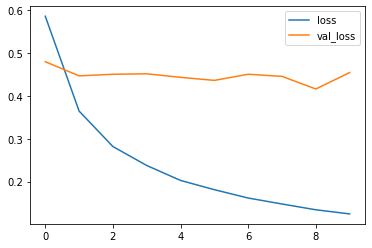

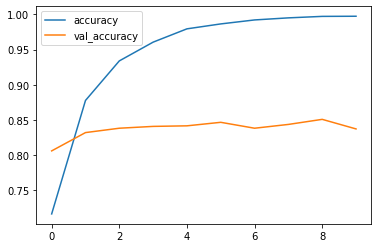

In [315]:
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.close()

plt.plot(model.history.history['accuracy'], label='accuracy')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.close()